# Learning Curves Example
Code to accompany an introductory [blog post](http://ryankresse.com/plotting-learning-curves/) on learning curves.

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
matplotlib.rcParams['axes.titlesize'] = 14


## Create fake learning curves for demonstration purposes

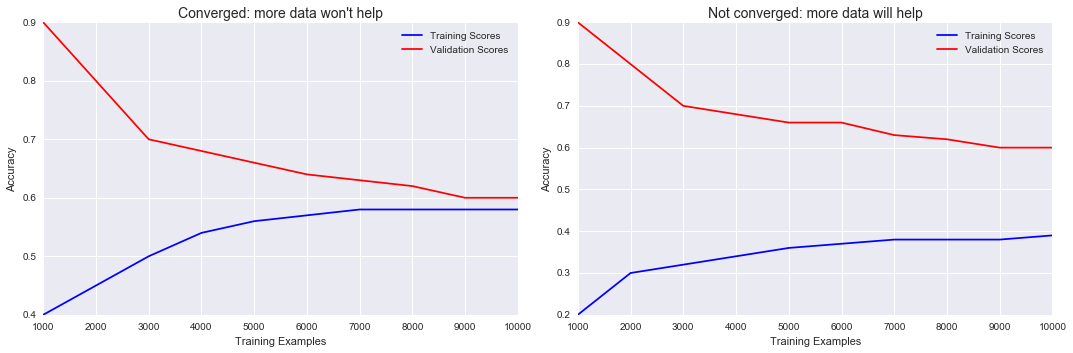

In [135]:
sampleSizes = np.linspace(1000, 10000, 10)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
fakeTestScoresConverge = [0.9, 0.8, 0.7, 0.68, 0.66, 0.64, 0.63, 0.62, 0.60, 0.60]
fakeTrainScoresConverge = [0.4, 0.45, 0.5, 0.54, 0.56, 0.57, 0.58, 0.58, 0.58, 0.58]
ax1.plot(sampleSizes,fakeTrainScoresConverge, color='blue', label='Training Scores')
ax1.plot(sampleSizes, fakeTestScoresConverge, color='red', label='Validation Scores')
ax1.legend(loc='best')
ax1.set_title('Converged: more data won\'t help')
ax1.set_xlabel('Training Examples')
ax1.set_ylabel('Accuracy')

fakeTestScoresNotConverged = [0.9, 0.8, 0.7, 0.68, 0.66, 0.66, 0.63, 0.62, 0.60, 0.60]
fakeTrainScoresNotConverged = [0.2, 0.3, 0.32, 0.34, 0.36, 0.37, 0.38, 0.38, 0.38, 0.39]
ax2.plot(sampleSizes,fakeTrainScoresNotConverged, color='blue', label='Training Scores')
ax2.plot(sampleSizes, fakeTestScoresNotConverged, color='red', label='Validation Scores')
ax2.legend(loc='best')

ax2.set_title('Not converged: more data will help')
ax2.set_xlabel('Training Examples')
ax2.set_ylabel('Accuracy')
fig.tight_layout()
plt.savefig('example_learning_curves.png', bbox_inches='tight')


## Recipes
Code to train a model and plot learning curves for the Kaggle [What's Cooking competition](https://www.kaggle.com/c/whats-cooking)

Read in the training data

In [3]:
train = pd.read_json('train.json', orient='records')
test = pd.read_json('test.json', orient='records')
allData = pd.concat([train, test])
allData.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


Create a string representation of the ingredients so that we can use sklearn's text feature extraction classes.

In [4]:
allData['ingredients_str'] = allData.ingredients.str.join(',')
allData.head()

,cuisine,id,ingredients,ingredients_str
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce,black olives,grape tomatoes,ga..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour,ground pepper,salt,tomatoes,ground..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs,pepper,salt,mayonaise,cooking oil,green c..."
3,indian,22213,"[water, vegetable oil, wheat, salt]","water,vegetable oil,wheat,salt"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","black pepper,shallots,cornflour,cayenne pepper..."


Learn a vocabulary for our ingredients.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(ngram_range =(1,2))
vec.fit(allData.ingredients_str)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

Split the data back into train and test sets.

In [7]:
train = allData.iloc[:train.shape[0], :]
test = allData.iloc[train.shape[0]:, :]

Label encode our target variable.

In [8]:
from sklearn.preprocessing import LabelEncoder
labEnc = LabelEncoder()
train['cuisine'] = labEnc.fit_transform(train.cuisine)

C:\Users\lid92al\WinPython-64bit-3.4.4.2\python-3.4.4.amd64\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Create our bag of words training features.

In [9]:
trainMatrix = vec.transform(train.ingredients_str)

Our helper function to plot learning curves.

In [28]:
def plot_learning_curve(trainSizes, trainScores, testScores, title="Learning Curve", filePath=None):
    fig, ax = plt.subplots(1,1, figsize=(9, 5))
    trainMeans =  np.mean(trainScores, axis=1)
    testMeans = np.mean(testScores, axis=1)

    ax.plot(trainSizes,trainMeans, color='blue', label='Training Scores')
    ax.plot(trainSizes, testMeans, color='red', label='Validation Scores')

    ax.set_title(title)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Number of examples')
    ax.legend(loc='best')
    if filePath:
        plt.savefig(filePath, bbox_inches='tight' )

Train a multinomial naive bayes model and plot the learning curves.

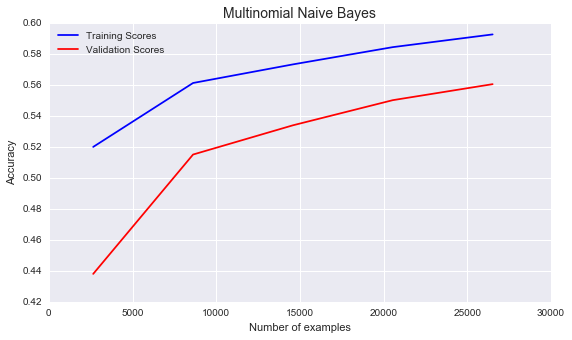

In [29]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.learning_curve import learning_curve
trainSizes, NBTrainScores, NBTestScores = learning_curve(MultinomialNB(), trainMatrix, train.cuisine)
plot_learning_curve(trainSizes, NBTrainScores, NBTestScores, title='Multinomial Naive Bayes', filePath='mnb.png')

Train a logistic regression model and plot the learning curve.

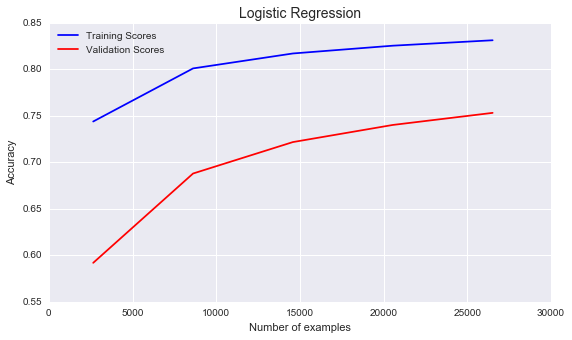

In [30]:
from sklearn.linear_model import LogisticRegression
trainSizes, lrTrainScores, lrTestScores = learning_curve(LogisticRegression(), trainMatrix, train.cuisine )
plot_learning_curve(trainSizes, lrTrainScores, lrTestScores, title='Logistic Regression', filePath='lr.png')

Train a SVM and plot the learning curve

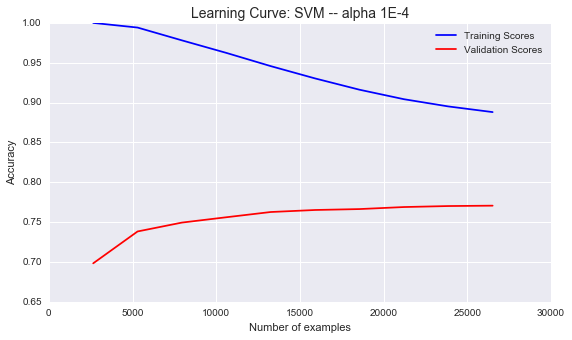

In [31]:
from sklearn.linear_model import SGDClassifier 
sampleSizes = np.linspace(.1, 1.0, 10)
trainSizes, svmTrainScores, svmTestScores = learning_curve(SGDClassifier(alpha=1E-4), trainMatrix, train.cuisine, sampleSizes)
plot_learning_curve(trainSizes, svmTrainScores, svmTestScores, title='Learning Curve: SVM -- alpha 1E-4', filePath='svm.png')

## Create a submission

Fit the SVM to all the training data.

In [24]:
clf = SGDClassifier(alpha=1E-4)
clf.fit(trainMatrix, train.cuisine)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

Create the bag of words features for the test set.

In [25]:
testMatrix = vec.transform(test.ingredients_str)

Make predictions, transform the numeric cusine labels back into their string representations, and write the submission to disk.

In [26]:
predictions = clf.predict(testMatrix)
submission = pd.DataFrame({'id': test.id, 'cuisine': predictions})
submission['cuisine'] = labEnc.inverse_transform(submission.cuisine)
submission.to_csv('submission.csv', index=False)